In [2]:
# connect to google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
# Define the TRAIN folder path
data_dir = '/content/gdrive/MyDrive/archive/dataset2-master/dataset2-master/images/TRAIN'

# Define the class labels
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Store file paths and labels
filepaths = []
labels = []

# Loop through each class folder
for label in class_labels:
    class_folder = os.path.join(data_dir, label)
    for file in os.listdir(class_folder):
        if file.endswith('.jpeg') or file.endswith('.png'):
            filepaths.append(os.path.join(class_folder, file))
            labels.append(label)

# Create a DataFrame
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

# Show top 5 entries
bloodCell_df.head()

,filepaths,labels
0,/content/gdrive/MyDrive/archive/dataset2-maste...,MONOCYTE
1,/content/gdrive/MyDrive/archive/dataset2-maste...,EOSINOPHIL
2,/content/gdrive/MyDrive/archive/dataset2-maste...,LYMPHOCYTE
3,/content/gdrive/MyDrive/archive/dataset2-maste...,MONOCYTE
4,/content/gdrive/MyDrive/archive/dataset2-maste...,EOSINOPHIL


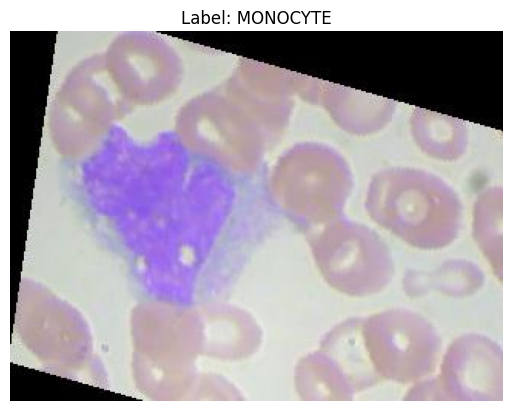

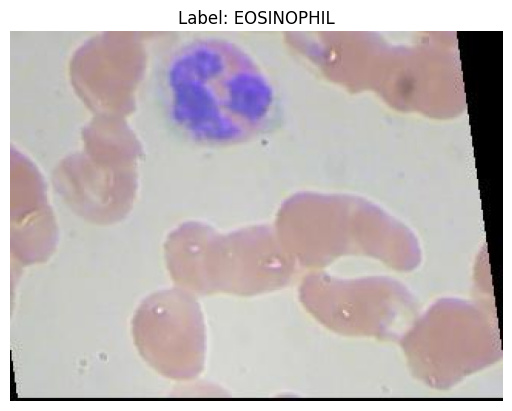

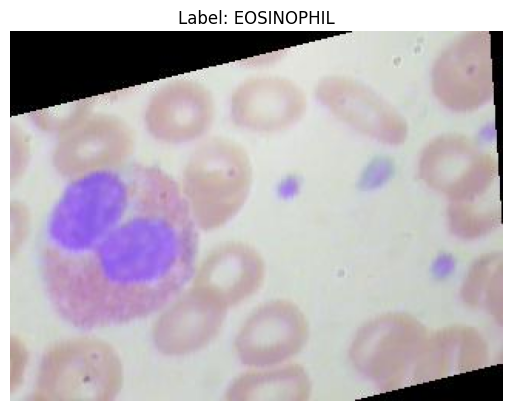

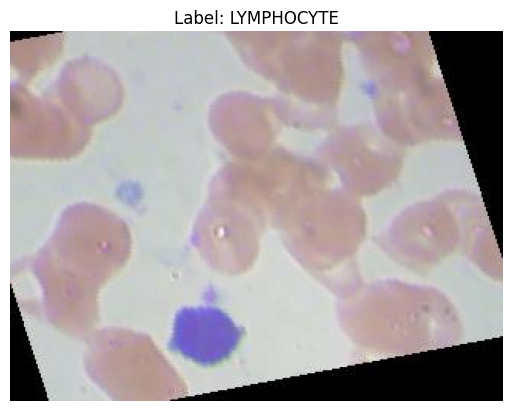

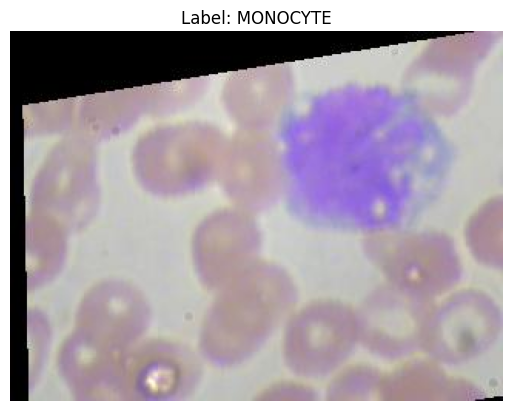

In [5]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Show 5 random images
for i in range(5):
    img_path = random.choice(bloodCell_df['filepaths'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label: {bloodCell_df[bloodCell_df['filepaths'] == img_path]['labels'].values[0]}")
    plt.axis('off')
    plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Create training and validation generators with augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Define image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_generator = datagen.flow_from_directory(
    directory='/content/gdrive/MyDrive/archive/dataset2-master/dataset2-master/images/TRAIN',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory='/content/gdrive/MyDrive/archive/dataset2-master/dataset2-master/images/TRAIN',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 8017 images belonging to 4 classes.
Found 2001 images belonging to 4 classes.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base (without top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (don’t train them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Start with 10; you can increase to 15–20 later
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2745s 11s/step - accuracy: 0.3271 - loss: 1.5561 - val_accuracy: 0.5302 - val_loss: 1.0872
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 583ms/step - accuracy: 0.4852 - loss: 1.1543 - val_accuracy: 0.6022 - val_loss: 0.9458
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 587ms/step - accuracy: 0.5781 - loss: 1.0025 - val_accuracy: 0.6502 - val_loss: 0.8647
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 583ms/step - accuracy: 0.5979 - loss: 0.9653 - val_accuracy: 0.6772 - val_loss: 0.8001
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 584ms/step - accuracy: 0.6381 - loss: 0.8858 - val_accuracy: 0.7181 - val_loss: 0.7528
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 201s 582ms/step - accuracy: 0.6558 - loss: 0.8531 - val_accuracy: 0.7146 - val_loss: 0.7343
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 585ms/step - accuracy: 0.6681 - loss: 0.8127 - val_accuracy: 0.7351 - val_loss: 0.6877
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 587ms/step - accuracy: 0.6824 - 

In [9]:
model.save("Blood_cell.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 518ms/step

Classification Report:

              precision    recall  f1-score   support

  EOSINOPHIL       0.26      0.21      0.23       503
  LYMPHOCYTE       0.26      0.31      0.28       500
    MONOCYTE       0.24      0.25      0.25       495
  NEUTROPHIL       0.24      0.23      0.24       503

    accuracy                           0.25      2001
   macro avg       0.25      0.25      0.25      2001
weighted avg       0.25      0.25      0.25      2001



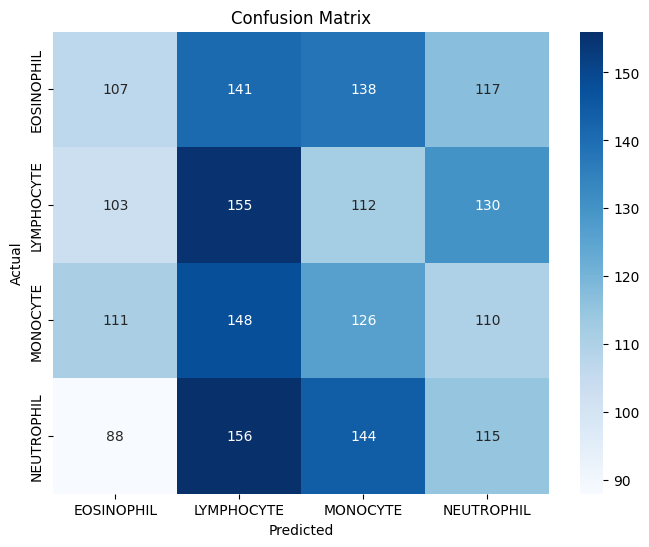

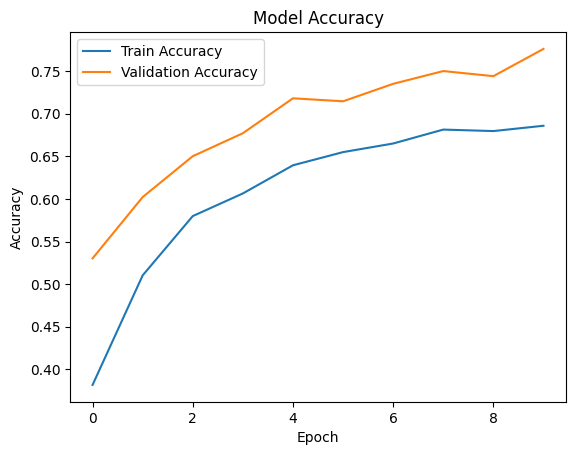

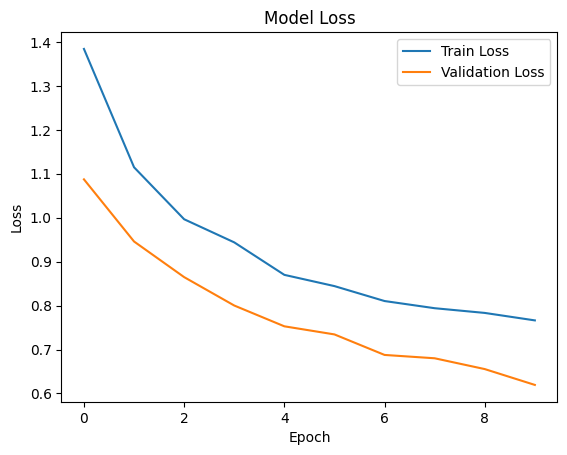

In [10]:
# ✅ Evaluation: Confusion Matrix + Classification Report + Accuracy/Loss Plots

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Reset the validation generator
val_generator.reset()

# Step 2: Predict labels
predictions = model.predict(val_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = val_generator.classes

# Step 3: Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

# Step 4: Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 6: Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()